In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Preprocessing - Training and testing split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Exploratory Data Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import  KNeighborsRegressor

import xgboost as xg
from sklearn.kernel_ridge import KernelRidge

#Evaluation: 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

## Loading Training/Testing Data:

In [3]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

train_df = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
test_df = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# This is for checking datatypes
# train_df.info()
# test_df.info()

## Data Preprocessing:

 Missing Data Imputation - train_df

In [5]:
def missing_cnt_percent(df):
    # create df that consists of columns and the number of missing values for each 
    data = df.isnull().sum().sort_values(ascending=False)
    missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

    # add column and fill it with the percentage of those missing values
    missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/df.shape[0] * 100)) 
    missing_df = missing_df[missing_df.missing_cnt > 0]
    print(missing_df)

In [6]:
missing_cnt_percent(train_df)

              missing_cnt percent_missing
PoolQC               1453           99.52
MiscFeature          1406           96.30
Alley                1369           93.77
Fence                1179           80.75
FireplaceQu           690           47.26
LotFrontage           259           17.74
GarageType             81            5.55
GarageCond             81            5.55
GarageFinish           81            5.55
GarageQual             81            5.55
GarageYrBlt            81            5.55
BsmtFinType2           38            2.60
BsmtExposure           38            2.60
BsmtQual               37            2.53
BsmtCond               37            2.53
BsmtFinType1           37            2.53
MasVnrArea              8            0.55
MasVnrType              8            0.55
Electrical              1            0.07


In [7]:
# These columns has NA value that is different from null(NaN)!
train_df.update(train_df[['PoolQC']].fillna('NA'))
train_df.update(train_df[['MiscFeature']].fillna('NA'))
train_df.update(train_df[['Alley']].fillna('NA'))
train_df.update(train_df[['Fence']].fillna('NA'))
train_df.update(train_df[['FireplaceQu']].fillna('NA'))

In [8]:
# All 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond' columns has 1379 not null values!
# So, I tested the theory that exactly same rows has null for these columns!
# All 81 do not have Garage! So, we can put zero/'NA' instead!
# train_df.loc[:,['GarageCars','GarageArea','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond']][train_df['GarageType'].isnull()]

# All 81 do not have Garage! So, we can put zero/'NA' instead!
train_df.update(train_df[['GarageYrBlt','GarageCars']].fillna(0))
train_df.update(train_df[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna('NA'))

In [9]:
# Same for Basement: 'BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1'
# train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtCond'].isnull()]

# All 37 do not have Garage! So, we can put 'NA' instead!
train_df.update(train_df[['BsmtQual','BsmtCond','BsmtFinType1']].fillna('NA'))
# Same for Basement: 'BsmtFinType2','BsmtExposure'
# train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtExposure'].isnull()]
train_df.at[949,'BsmtExposure']='No'
# train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtFinType2'].isnull()]
# I'm going with 'Average Living Quarters'
train_df.at[333,'BsmtFinType2']='ALQ'
train_df.update(train_df[['BsmtFinType2','BsmtExposure']].fillna('NA'))
train_df.update(train_df[['Electrical']].fillna('SBrkr'))
#I'm not professional but I think there is no Masonry veneer type for the Vinyl and Cement!
train_df.at[530,'MasVnrType']='Stone'

# train_df['Set_of_Numbers'] = train_df['Set_of_Numbers'].fillna(0)
train_df.update(train_df[['MasVnrArea']].fillna(0))
train_df.update(train_df[['MasVnrType']].fillna('None'))
train_df['LotFrontage'] = train_df['LotFrontage'].fillna((train_df['LotFrontage'].mean()))

In [10]:
missing_cnt_percent(train_df)

Empty DataFrame
Columns: [missing_cnt, percent_missing]
Index: []


## Convert categorical string to numeric

Categorical Variable Analysis for ordered categories

In [11]:
# LotShape
quality_ratings1 = {
    "IR3" : 1,
	"IR2" : 2,
	"IR1" : 3,
	"Reg" : 4
}
train_df["LotShape_Num"] = train_df.LotShape.map(quality_ratings1)
test_df["LotShape_Num"] = test_df.LotShape.map(quality_ratings1)

In [12]:
	# LandContour
quality_ratings2 = {
	"Low" : 1,
	"HLS" : 2,
	"Bnk" : 3,
	"Lvl" : 4
}
train_df["LandContour_Num"] = train_df.LandContour.map(quality_ratings2)
test_df["LandContour_Num"] = test_df.LandContour.map(quality_ratings2)

In [13]:
	# LandSlope
quality_ratings3 = {
	"Sev" : 1,
	"Mod" : 2,
	"Gtl" : 3
}
train_df["LandSlope_Num"] = train_df.LandSlope.map(quality_ratings3)
test_df["LandSlope_Num"] = test_df.LandSlope.map(quality_ratings3)

In [14]:
	# ExterQual, ExterCond, HeatingQC, KitchenQual
quality_ratings4 = {
	"Po" : 1,
	"Fa" : 2,
	"TA" : 3,
	"Gd" : 4,
	"Ex" : 5
}
train_df["ExterQual_Num"] = train_df.ExterQual.map(quality_ratings4)
train_df["ExterCond_Num"] = train_df.ExterCond.map(quality_ratings4)
train_df["HeatingQC_Num"] = train_df.HeatingQC.map(quality_ratings4)
train_df["KitchenQual_Num"] = train_df.KitchenQual.map(quality_ratings4)

test_df["ExterQual_Num"] = test_df.ExterQual.map(quality_ratings4)
test_df["ExterCond_Num"] = test_df.ExterCond.map(quality_ratings4)
test_df["HeatingQC_Num"] = test_df.HeatingQC.map(quality_ratings4)
test_df["KitchenQual_Num"] = test_df.KitchenQual.map(quality_ratings4)

In [15]:
	# BsmtQual, BsmtCond, GarageQual, GarageCond, FireplaceQu
quality_ratings5 = {
	"NA" : 1,
	"Po" : 2,
	"Fa" : 3,
	"TA" : 4,
	"Gd" : 5,
	"Ex" : 6
}
train_df["BsmtQual_Num"] = train_df.BsmtQual.map(quality_ratings5)
train_df["BsmtCond_Num"] = train_df.BsmtCond.map(quality_ratings5)
train_df["GarageQual_Num"] = train_df.GarageQual.map(quality_ratings5)
train_df["GarageCond_Num"] = train_df.GarageCond.map(quality_ratings5)
train_df["FireplaceQu_Num"] = train_df.FireplaceQu.map(quality_ratings5)

test_df["BsmtQual_Num"] = test_df.BsmtQual.map(quality_ratings5)
test_df["BsmtCond_Num"] = test_df.BsmtCond.map(quality_ratings5)
test_df["GarageQual_Num"] = test_df.GarageQual.map(quality_ratings5)
test_df["GarageCond_Num"] = test_df.GarageCond.map(quality_ratings5)
test_df["FireplaceQu_Num"] = test_df.FireplaceQu.map(quality_ratings5)

In [16]:
	# BsmtExposure
quality_ratings7 = {
	"NA" : 1,
	"No" : 2,
	"Mn" : 3,
	"Av" : 4,
	"Gd" : 5
}
train_df["BsmtExposure_Num"] = train_df.BsmtExposure.map(quality_ratings7)
test_df["BsmtExposure_Num"] = test_df.BsmtExposure.map(quality_ratings7)

In [17]:
	# BsmtFinType1, BsmtFinType2
quality_ratings8 = {
	"NA" : 1,
	"Unf" : 2,
	"LwQ" : 3,
	"Rec" : 4,
	"BLQ" : 5,
	"ALQ" : 6,
	"GLQ" : 7
}
train_df["BsmtFinType1_Num"] = train_df.BsmtFinType1.map(quality_ratings8)
train_df["BsmtFinType2_Num"] = train_df.BsmtFinType2.map(quality_ratings8)

test_df["BsmtFinType1_Num"] = test_df.BsmtFinType1.map(quality_ratings8)
test_df["BsmtFinType2_Num"] = test_df.BsmtFinType2.map(quality_ratings8)

In [18]:
	# Functional
quality_ratings9 = {
	"Sal" : 1,
	"Sev" : 2,
	"Maj2" : 3,
	"Maj1" : 4,
	"Mod" : 5,
	"Min2" : 6,
	"Min1" : 7,
	"Typ" : 8
}
train_df["Functional_Num"] = train_df.Functional.map(quality_ratings9)

test_df["Functional_Num"] = test_df.Functional.map(quality_ratings9)

In [19]:
	# GarageFinish
quality_ratings10 = {
	"NA" : 1,
	"Unf" : 2,
	"RFn" : 3,
	"Fin" : 4
}
train_df["GarageFinish_Num"] = train_df.GarageFinish.map(quality_ratings10)

test_df["GarageFinish_Num"] = test_df.GarageFinish.map(quality_ratings10)

In [20]:
	# CentralAir
quality_ratings11 = {
	"N" : 1,
	"Y" : 2
}
train_df["CentralAir_Num"] = train_df.CentralAir.map(quality_ratings11)

test_df["CentralAir_Num"] = test_df.CentralAir.map(quality_ratings11)

In [21]:
	# PavedDrive
quality_ratings12 = {
	"N" : 1,
	"P" : 2,
	"Y" : 3
}
train_df["PavedDrive_Num"] = train_df.PavedDrive.map(quality_ratings12)

test_df["PavedDrive_Num"] = test_df.PavedDrive.map(quality_ratings12)

In [22]:
	# PoolQC
quality_ratings6 = {
	"NA" : 1,
	"Fa" : 2,
	"TA" : 3,
	"Gd" : 4,
	"Ex" : 5
}
train_df["PoolQC_Num"] = train_df.PoolQC.map(quality_ratings6)
test_df["PoolQC_Num"] = test_df.PoolQC.map(quality_ratings6)

In [23]:
	# MSSubClass
quality_ratings7 = {
    20:"St46nNAS", 
    30:"St45nOl", 
    40:"StwFinAAA", 
    45:"HalfStUnfinAAA", 
    50:"HalfStFinAA",
    60:"St46nN", 
    70:"St45nOl", 
    75:"HalfStAA", 
    80:"SplorML", 
    85:"SplFoy", 
    90:"DupASnA", 
    120:"StPud46nN", 
    150:"HalfStPudAA", 
    160:"StPud46nNN", 
    180:"PudML", 190:"FamConv"
}
train_df["MSSubClass_Cat"] = train_df.MSSubClass.map(quality_ratings7)
test_df["MSSubClass_Cat"] = test_df.MSSubClass.map(quality_ratings7)

In [24]:
# drop the columns where we replaced with numbers
drop_cols = ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual','GarageQual','LotShape','LandContour','LandSlope','ExterCond','BsmtCond','GarageCond','FireplaceQu','BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','GarageFinish','CentralAir','PavedDrive','PoolQC','MSSubClass']

for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

## Exploratory Data Analysis (EDA)

- Correlation 

In [25]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
print_full(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice           1.0000
OverallQual         0.7910
GrLivArea           0.7086
ExterQual_Num       0.6826
KitchenQual_Num     0.6596
GarageCars          0.6404
GarageArea          0.6234
TotalBsmtSF         0.6136
1stFlrSF            0.6059
BsmtQual_Num        0.5852
FullBath            0.5607
GarageFinish_Num    0.5492
TotRmsAbvGrd        0.5337
YearBuilt           0.5229
FireplaceQu_Num     0.5204
YearRemodAdd        0.5071
MasVnrArea          0.4726
Fireplaces          0.4669
HeatingQC_Num       0.4276
BsmtFinSF1          0.3864
BsmtExposure_Num    0.3750
LotFrontage         0.3349
WoodDeckSF          0.3244
2ndFlrSF            0.3193
OpenPorchSF         0.3159
BsmtFinType1_Num    0.3049
HalfBath            0.2841
GarageQual_Num      0.2738
LotArea             0.2638
GarageCond_Num      0.2632
GarageYrBlt         0.2614
CentralAir_Num      0.2513
PavedDrive_Num      0.2314
BsmtFullBath        0.2271
BsmtUnfSF           0.2145
BsmtCond_Num        0.2126
BedroomAbvGr        0.1682
P

In [26]:
corr_matrix[(corr_matrix.SalePrice<0.3) & (corr_matrix.SalePrice>-0.3)].SalePrice.sort_values(ascending=False)

HalfBath            0.2841
GarageQual_Num      0.2738
LotArea             0.2638
GarageCond_Num      0.2632
GarageYrBlt         0.2614
CentralAir_Num      0.2513
PavedDrive_Num      0.2314
BsmtFullBath        0.2271
BsmtUnfSF           0.2145
BsmtCond_Num        0.2126
BedroomAbvGr        0.1682
PoolQC_Num          0.1155
ScreenPorch         0.1114
Functional_Num      0.1076
PoolArea            0.0924
MoSold              0.0464
3SsnPorch           0.0446
ExterCond_Num       0.0189
BsmtFinType2_Num   -0.0003
BsmtFinSF2         -0.0114
BsmtHalfBath       -0.0168
MiscVal            -0.0212
LowQualFinSF       -0.0256
YrSold             -0.0289
LandSlope_Num      -0.0512
LandContour_Num    -0.0730
OverallCond        -0.0779
EnclosedPorch      -0.1286
KitchenAbvGr       -0.1359
LotShape_Num       -0.2678
Name: SalePrice, dtype: float64

In [27]:
train_df['TotSF_Factor'] = train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']
train_df["AddedArea_Factor"] = train_df["GrLivArea"] + train_df["GarageArea"]
train_df["TotBath_Factor"] = train_df["FullBath"] + (train_df["HalfBath"]*0.5)
train_df['Overall_Factor'] = train_df['OverallQual'] * train_df['OverallCond'] * train_df['YearBuilt']
train_df['Yr_Factor'] = train_df['YrSold'] - np.maximum(train_df['YearBuilt'],train_df['YearRemodAdd'])
train_df['Pool_Factor'] = train_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_df['OpenOR3SsnPorch_Factor'] = train_df["OpenPorchSF"].apply(lambda x: 1 if x > 0 else 0) + train_df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0) + train_df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
train_df['Kitchen2Flr_Ratio'] = train_df['KitchenAbvGr'] / (train_df['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0) + train_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) + train_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0))


In [28]:
missing_cnt_percent(test_df)

                  missing_cnt percent_missing
PoolQC_Num               1456           99.79
MiscFeature              1408           96.50
Alley                    1352           92.67
Fence                    1169           80.12
FireplaceQu_Num           730           50.03
LotFrontage               227           15.56
GarageQual_Num             78            5.35
GarageCond_Num             78            5.35
GarageFinish_Num           78            5.35
GarageYrBlt                78            5.35
GarageType                 76            5.21
BsmtCond_Num               45            3.08
BsmtQual_Num               44            3.02
BsmtExposure_Num           44            3.02
BsmtFinType1_Num           42            2.88
BsmtFinType2_Num           42            2.88
MasVnrType                 16            1.10
MasVnrArea                 15            1.03
MSZoning                    4            0.27
BsmtHalfBath                2            0.14
Utilities                   2     

In [29]:
test_df.update(test_df[['GarageArea','GarageCars','TotalBsmtSF','BsmtFinSF1','BsmtUnfSF','GarageYrBlt','BsmtFullBath','MasVnrArea']].fillna(0))
test_df.update(test_df[['BsmtQual_Num','BsmtFinType2_Num','GarageFinish_Num','FireplaceQu_Num','Functional_Num','BsmtFinType1_Num','GarageQual_Num','GarageCond_Num','BsmtCond_Num']].fillna(1))
test_df.update(test_df[['BsmtExposure_Num']].fillna(2))
test_df.update(test_df[['KitchenQual_Num']].fillna(3))
test_df['LotFrontage'] = test_df['LotFrontage'].fillna((test_df['LotFrontage'].mean()))

In [30]:
test_df['TotSF_Factor'] = test_df['1stFlrSF']+test_df['2ndFlrSF']+test_df['TotalBsmtSF']
test_df["AddedArea_Factor"] = test_df["GrLivArea"] + test_df["GarageArea"]
test_df["TotBath_Factor"] = test_df["FullBath"] + (test_df["HalfBath"]*0.5)
test_df['Overall_Factor'] = test_df['OverallQual'] * test_df['OverallCond'] * test_df['YearBuilt']
test_df['Yr_Factor'] = test_df['YrSold'] - np.maximum(test_df['YearBuilt'],test_df['YearRemodAdd'])
test_df['Pool_Factor'] = test_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_df['OpenOR3SsnPorch_Factor'] = test_df["OpenPorchSF"].apply(lambda x: 1 if x > 0 else 0) + test_df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0) + test_df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
test_df['Kitchen2Flr_Ratio'] = test_df['KitchenAbvGr'] / (test_df['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0) + test_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) + test_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0))

In [31]:
drop_cols = ['MoSold','3SsnPorch','ExterCond_Num','BsmtFinType2_Num','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF',
             'YrSold','Street','Utilities','LandSlope_Num','PoolQC_Num','MiscFeature']
# drop_cols = ['HalfBath', 'GarageQual_Num','LotArea','GarageCond_Num', 'GarageYrBlt', 'CentralAir_Num',
#              'PavedDrive_Num','BsmtFullBath','BsmtUnfSF','BsmtCond_Num','BedroomAbvGr','ScreenPorch',
#              'Street','Utilities','Functional_Num','Pool_Factor','PoolArea','LandContour_Num','OverallCond','EnclosedPorch',
#              'MiscFeature','KitchenAbvGr','Kitchen2Flr_Ratio','LotShape_Num','PoolQC_Num']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [32]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
print_full(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice                 1.0000
OverallQual               0.7910
TotSF_Factor              0.7823
AddedArea_Factor          0.7736
GrLivArea                 0.7086
ExterQual_Num             0.6826
KitchenQual_Num           0.6596
GarageCars                0.6404
GarageArea                0.6234
TotalBsmtSF               0.6136
1stFlrSF                  0.6059
TotBath_Factor            0.5980
Overall_Factor            0.5938
BsmtQual_Num              0.5852
FullBath                  0.5607
GarageFinish_Num          0.5492
TotRmsAbvGrd              0.5337
YearBuilt                 0.5229
FireplaceQu_Num           0.5204
YearRemodAdd              0.5071
MasVnrArea                0.4726
OpenOR3SsnPorch_Factor    0.4707
Fireplaces                0.4669
HeatingQC_Num             0.4276
BsmtFinSF1                0.3864
BsmtExposure_Num          0.3750
LotFrontage               0.3349
WoodDeckSF                0.3244
2ndFlrSF                  0.3193
OpenPorchSF               0.3159
BsmtFinTyp

In [33]:
corr_matrix[(corr_matrix.SalePrice<0.3) & (corr_matrix.SalePrice>-0.3)].SalePrice.sort_values(ascending=False)

HalfBath             0.2841
GarageQual_Num       0.2738
LotArea              0.2638
GarageCond_Num       0.2632
GarageYrBlt          0.2614
CentralAir_Num       0.2513
PavedDrive_Num       0.2314
BsmtFullBath         0.2271
BsmtUnfSF            0.2145
BsmtCond_Num         0.2126
BedroomAbvGr         0.1682
ScreenPorch          0.1114
Functional_Num       0.1076
Pool_Factor          0.0937
PoolArea             0.0924
LandContour_Num     -0.0730
OverallCond         -0.0779
EnclosedPorch       -0.1286
KitchenAbvGr        -0.1359
Kitchen2Flr_Ratio   -0.2042
LotShape_Num        -0.2678
Name: SalePrice, dtype: float64

In [34]:
drop_cols = ['KitchenAbvGr','PoolArea','OpenPorchSF','LandContour_Num','EnclosedPorch','ScreenPorch',
             'OverallCond','FullBath','HalfBath']
# drop_cols = ['MoSold','3SsnPorch','ExterCond_Num','BsmtFinType2_Num','BsmtFinSF2','BsmtHalfBath',
#              'MiscVal','LowQualFinSF','OpenPorchSF','FullBath','YrSold','LandSlope_Num']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

- Variance Inflation Factor

In [35]:
num_features = [col for col in train_df.columns if train_df[col].dtypes != 'O' and col not in "Id"]
train_df_vif = train_df.loc[:,train_df.columns.isin(num_features)]

In [36]:
X = add_constant(train_df_vif)
print_full(pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])], index=X.columns))

const                     2.433499e+06
LotFrontage               1.439343e+00
LotArea                   1.394992e+00
OverallQual               6.996395e+00
YearBuilt                 5.058669e+00
YearRemodAdd              2.546198e+02
MasVnrArea                1.438530e+00
BsmtFinSF1                9.959697e+00
BsmtUnfSF                 9.284505e+00
TotalBsmtSF                        inf
1stFlrSF                           inf
2ndFlrSF                           inf
GrLivArea                          inf
BsmtFullBath              2.158798e+00
BedroomAbvGr              2.424385e+00
TotRmsAbvGrd              4.763025e+00
Fireplaces                4.719187e+00
GarageYrBlt               1.392743e+01
GarageCars                6.324242e+00
GarageArea                         inf
WoodDeckSF                1.745717e+00
SalePrice                 5.718933e+00
LotShape_Num              1.241083e+00
ExterQual_Num             3.173202e+00
HeatingQC_Num             1.720778e+00
KitchenQual_Num          

In [37]:
drop_cols = ['GrLivArea','2ndFlrSF']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [38]:
num_features = [col for col in train_df.columns if train_df[col].dtypes != 'O' and col not in "Id"]
train_df_vif = train_df.loc[:,train_df.columns.isin(num_features)]

In [39]:
X = add_constant(train_df_vif)
print_full(pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])], index=X.columns))

const                     2.433499e+06
LotFrontage               1.439343e+00
LotArea                   1.394992e+00
OverallQual               6.996395e+00
YearBuilt                 5.058669e+00
YearRemodAdd              2.546198e+02
MasVnrArea                1.438530e+00
BsmtFinSF1                9.959697e+00
BsmtUnfSF                 9.284505e+00
TotalBsmtSF               1.047828e+02
1stFlrSF                  7.138822e+00
BsmtFullBath              2.158798e+00
BedroomAbvGr              2.424385e+00
TotRmsAbvGrd              4.763025e+00
Fireplaces                4.719187e+00
GarageYrBlt               1.392743e+01
GarageCars                6.324242e+00
GarageArea                2.813412e+01
WoodDeckSF                1.745717e+00
SalePrice                 5.718933e+00
LotShape_Num              1.241083e+00
ExterQual_Num             3.173202e+00
HeatingQC_Num             1.720778e+00
KitchenQual_Num           2.733500e+00
BsmtQual_Num              4.608338e+00
BsmtCond_Num             

## Outliers Analysis:

In [40]:
def outlier_thresholds(df, var):
    quartile1 = df[var].quantile(0.05)
    quartile3 = df[var].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(df, num_col_names):
    var_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(df, col)
        if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None):
            number_of_outliers = df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0]
            var_names.append(col)
    return var_names

def replace_with_thresholds(df, var):
    low_limit, up_limit = outlier_thresholds(df, var)
    df.loc[(df[var] < low_limit), var] = low_limit
    df.loc[(df[var] > up_limit), var] = up_limit

In [41]:
has_outliers(train_df, num_features)

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'BsmtFullBath',
 'BedroomAbvGr',
 'WoodDeckSF',
 'SalePrice',
 'LotShape_Num',
 'BsmtCond_Num',
 'Functional_Num',
 'TotSF_Factor',
 'AddedArea_Factor',
 'Pool_Factor',
 'Kitchen2Flr_Ratio']

In [42]:
for col in num_features:
    replace_with_thresholds(train_df, col)

has_outliers(train_df, num_features)

[]

## Categorical Variable Analysis for non-ordered categories

In [43]:
train_df = pd.get_dummies(data = train_df, columns = ["SaleCondition", "MSSubClass_Cat", "MSZoning", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
        "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", "GarageType", "SaleType", "Fence", "Alley"] , drop_first=True)

In [44]:
train_df.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,Alley_NA,Alley_Pave
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,7.0,2003.0,2003.0,196.0,706.0,150.0,856.0,856.0,...,0,0,0,1,0,0,0,1,1,0
2,80.0,9600.0,6.0,1976.0,1976.0,0.0,978.0,284.0,1262.0,1262.0,...,0,0,0,1,0,0,0,1,1,0
3,68.0,11250.0,7.0,2001.0,2002.0,162.0,486.0,434.0,920.0,920.0,...,0,0,0,1,0,0,0,1,1,0
4,60.0,9550.0,7.0,1915.0,1970.0,0.0,216.0,540.0,756.0,961.0,...,0,0,0,1,0,0,0,1,1,0
5,84.0,14260.0,8.0,2000.0,2000.0,350.0,655.0,490.0,1145.0,1145.0,...,0,0,0,1,0,0,0,1,1,0


In [45]:
test_df = pd.get_dummies(data = test_df, columns = ["SaleCondition", "MSSubClass_Cat", "MSZoning", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
        "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", "GarageType", "SaleType", "Fence", "Alley"] , drop_first=True)

In [46]:
train_cols = train_df.columns
test_cols = test_df.columns

train_not_test = train_cols.difference(test_cols)
train_not_test = train_not_test.drop(['SalePrice'])
test_df = pd.concat([test_df,pd.DataFrame(
    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],index=test_df.index, columns=train_not_test)], axis=1
)

In [47]:
train_cols = train_df.columns
test_cols = test_df.columns

test_not_train = test_cols.difference(train_cols)
train_df['MSSubClass_Cat_HalfStPudAA'] = 0

## Split data set into train dataset and test dataset 

In [48]:
#Independent variable:
x = train_df.loc[:,~train_df.columns.isin(['Id','SalePrice'])]

#dependent variable:
y = train_df.loc[:,'SalePrice']

In [49]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3,random_state=42)

# Model

In [50]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [51]:
def plotModel(predictions, fig_width=15, fig_height=6, dot_size=15, title='Actual vs Predicted Sale Price'):   
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    #Display number in decimal form, not scientific notation
    ax.ticklabel_format(style='plain', axis='y')
    ax.scatter(y_test, predictions, label='Predicted', s=dot_size, alpha=0.6)
    ax.plot(y_test, y_test, label='Actual', color='lightseagreen')
    
    ax.set_xlabel(r'Actual Sale Price', fontsize=15)   
    ax.set_ylabel(r'Predicted Sale Price', fontsize=15)    
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)

    ax.set_title(title)
    plt.legend(loc=2, prop={'size': 15})
    plt.show()  

## Linear Regression

In [52]:
ln_reg=LinearRegression()

In [53]:
ln_reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
ln_y_pred=ln_reg.predict(x_test)

In [55]:
print('MAPE = ', mean_absolute_percentage_error(y_test,ln_y_pred),
      '\nMSE = ', mean_squared_error(y_test,ln_y_pred),
      '\nr2_score = ', r2_score(y_test,ln_y_pred))

MAPE =  12.169423226153436 
MSE =  1235036390.887435 
r2_score =  0.8184154095313213


In [57]:
plotModel(ln_y_pred, title='Actual vs Predicted Sale Price [Linear Regression]')

## Decision Tree

In [58]:
regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [59]:
dt_y_pred=regressor_dt.predict(x_test)

In [60]:
# mean_absolute_percentage_error(y_test,dt_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,dt_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,dt_y_pred),
      '\nr2_score = ', r2_score(y_test,dt_y_pred))

MAPE =  13.801760025668964 
MSE =  1312587494.9337897 
r2_score =  0.8070132471557394


In [ ]:
plotModel(dt_y_pred, title='Actual vs Predicted Sale Price [Decision Tree]')

## SVR


- kernel = rbf


In [61]:
svr_regressor = SVR(kernel = 'rbf')

In [62]:
svr_regressor.fit(x_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [63]:
svr_y_pred = svr_regressor.predict(x_test)

In [64]:
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_y_pred))

MAPE =  33.275696308757524 
MSE =  7017681056.184142 
r2_score =  -0.03179367833149627


## Random Forest

In [65]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
rf_y_pred = rf_regressor.predict(x_test)

In [67]:
print('MAPE = ', mean_absolute_percentage_error(y_test,rf_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,rf_y_pred),
      '\nr2_score = ', r2_score(y_test,rf_y_pred))

MAPE =  9.067093947316483 
MSE =  645098160.3526893 
r2_score =  0.9051526852779048


In [ ]:
plotModel(rf_y_pred, title='Actual vs Predicted Sale Price [Random Tree]')

## LASSO regression

In [68]:
lasso_regressor = LassoCV()
lasso_regressor.fit(x_train,y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [69]:
lasso_y_pred=lasso_regressor.predict(x_test)

In [70]:
print('MAPE = ', mean_absolute_percentage_error(y_test,lasso_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,lasso_y_pred),
      '\nr2_score = ', r2_score(y_test,lasso_y_pred))

MAPE =  14.368569014205281 
MSE =  1319515638.39832 
r2_score =  0.8059946179857835


## Ridge Regression

In [71]:
ridge_regressor = RidgeCV()
ridge_regressor.fit(x_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [72]:
ridge_y_pred = ridge_regressor.predict(x_test)

In [73]:
print('MAPE = ', mean_absolute_percentage_error(y_test,ridge_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,ridge_y_pred),
      '\nr2_score = ', r2_score(y_test,ridge_y_pred))

MAPE =  11.410621055845652 
MSE =  753942527.8204751 
r2_score =  0.889149545583164


## XGBoost Regression:

In [74]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 123,
                        subsample=0.75, learning_rate=0.1)

In [75]:
# Fitting the model 
xgb_r.fit(x_train, y_train) 
  
# Predict the model 
xgb_pred = xgb_r.predict(x_test) 
  
# MSE 
mse = mean_squared_error(y_test, xgb_pred)

# r2 score
r2 = r2_score(y_test, xgb_pred)

# variance score
var_score = explained_variance_score(y_test, xgb_pred)

# MAPE
mape = mean_absolute_percentage_error(y_test, xgb_pred)

print("MAPE: %.2f" %(mape) + '%')
print("MSE: %.2f" %(mse)) 
print("r2_score: %f" %(r2))
print("variance score: %.2f" %(var_score))


MAPE: 8.74%
MSE: 612027985.13
r2_score: 0.910015
variance score: 0.91


In [ ]:
plotModel(xgb_pred, title='Actual vs Predicted Sale Price [XGBoost]')

## ElasticNet Regression

In [76]:
el_regressor = ElasticNetCV()
el_regressor.fit(x_train,y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [77]:
el_y_pred=el_regressor.predict(x_test)

In [78]:
print('MAPE = ', mean_absolute_percentage_error(y_test,el_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,el_y_pred),
      '\nr2_score = ', r2_score(y_test,el_y_pred))

MAPE =  17.584945833231416 
MSE =  2149362937.7800574 
r2_score =  0.6839840577127414


## KNeighbors

In [79]:
kn_regressor = KNeighborsRegressor(n_neighbors=3)
kn_regressor.fit(x_train, y_train)
kn_y_pred = kn_regressor.predict(x_test)
print('MAPE = ', mean_absolute_percentage_error(y_test,kn_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,kn_y_pred),
      '\nr2_score = ', r2_score(y_test,kn_y_pred))

MAPE =  14.389592661459616 
MSE =  1848535878.7044644 
r2_score =  0.7282139757355515


## Kernel Ridge Regression

In [80]:
kernelRidge = KernelRidge(alpha=0.1, degree=2, coef0=1.3)
kernelRidge.fit(x_train,y_train)
y_pred_KRM = kernelRidge.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_KRM))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_KRM))

print('MAPE: %.2f'
      % np.mean(np.abs((y_test - y_pred_KRM) / y_test)),
     '\nMAPE function ==',mean_absolute_percentage_error(y_test,y_pred_KRM)) 

Mean squared error: 865552687.10
Coefficient of determination: 0.87
MAPE: 0.12 
MAPE function == 12.313258863354507


## Gradient Boost Regression

In [81]:
gbr = GradientBoostingRegressor(random_state=42, subsample = 0.6, max_features=10, min_samples_split=4,
                                n_estimators=3000, learning_rate = 0.01)

gbr.fit(x_train,y_train)
y_pred_GBR = gbr.predict(x_test)
# gradientBoosting_model = gbr.fit(x_train,y_train)
# y_pred_GBR = gradientBoosting_model.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_GBR))


print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_GBR))

print('MAPE: %.2f'
      % np.mean(np.abs((y_test - y_pred_GBR)) / y_test),
     '\nMAPE function ==',mean_absolute_percentage_error(y_test,y_pred_GBR))

Mean squared error: 528014218.44
Coefficient of determination: 0.92
MAPE: 0.09 
MAPE function == 8.882565799677128


In [ ]:
plotModel(y_pred_GBR, title='Actual vs Predicted Sale Price [Gradient Boost]')

In [82]:
y_pred_3 = (y_pred_GBR + xgb_pred + rf_y_pred)/3

In [83]:
print('MAPE = ', mean_absolute_percentage_error(y_test,y_pred_3), 
      '\nMSE = ', mean_squared_error(y_test,y_pred_3),
      '\nr2_score = ', r2_score(y_test,y_pred_3))

MAPE =  8.425827992780878 
MSE =  533318677.6960251 
r2_score =  0.9215873682805866


In [86]:
plotModel(y_pred_3, title='Actual vs Predicted Sale Price [Combination]')

In [85]:
y_pred_4 = (0.3*y_pred_GBR + 0.4*xgb_pred + 0.2*rf_y_pred + 0.1*ridge_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,y_pred_4), 
      '\nMSE = ', mean_squared_error(y_test,y_pred_4),
      '\nr2_score = ', r2_score(y_test,y_pred_4))

MAPE =  8.2958376668551 
MSE =  521777877.24538976 
r2_score =  0.9232841859120116


# Actual Test

In [87]:
rf_actual = RandomForestRegressor()
rf_actual.fit(x,y)

kr_actual = KernelRidge(alpha=0.1, degree=2, coef0=1.3)
kr_actual.fit(x,y)

kn_actual = KNeighborsRegressor(n_neighbors=3)
kn_actual.fit(x, y)

ridge_actual = RidgeCV()
ridge_actual.fit(x,y)

gbr_actual = GradientBoostingRegressor(random_state=42, subsample = 0.6, max_features=10, min_samples_split=4,
                                    n_estimators=3000, learning_rate = 0.01)
gbr_actual.fit(x,y)

xgb_actual = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 123,
                            subsample=0.75, learning_rate=0.1)
xgb_actual.fit(x.values,y)

In [187]:
def PyLovers_Model(x, y, X_test):
    return(( 0.4 * xgb_actual.predict(X_TEST.values) + 
            0.3 * rf_actual.predict(X_test) +
            0.1 * gbr_actual.predict(X_TEST.values) +
            0.15 * kn_actual.predict(X_test) +          
            0.05 * ridge_actual.predict(X_test)))

In [88]:
test_df = test_df.sort_values(by=['Id'])

X_TEST = test_df.loc[:,~test_df.columns.isin(['Id'])]

In [89]:
test_actual_price_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test_actual_price.csv'

test_actual_price_df = pd.read_csv(test_actual_price_url, low_memory=False, error_bad_lines=False, index_col='Id')
test_actual_price_df = test_actual_price_df.sort_values(by=['Id'])
Y_TEST = test_actual_price_df.loc[:,'SalePrice']

In [188]:
Y_PRED = PyLovers_Model(x, y, X_TEST)

print('MAPE = ', mean_absolute_percentage_error(Y_TEST,Y_PRED), 
      '\nMSE = ', mean_squared_error(Y_TEST,Y_PRED),
      '\nr2_score = ', r2_score(Y_TEST,Y_PRED))

MAPE =  8.999914982208443 
MSE =  515249975.7860307 
r2_score =  0.9204788203822077


In [ ]:
# plotModel(y_pred, title='Actual vs Predicted Sale Price [Combination]')

Another Feature Engineering on Sales Price

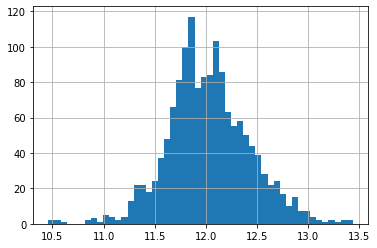

In [97]:
(np.log(y)).hist(bins = 50)

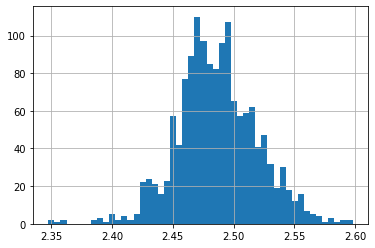

In [98]:
y_log = np.log(y)
(np.log(y_log)).hist(bins = 50)

In [99]:
rf_actual_log = RandomForestRegressor()
rf_actual_log.fit(x,y_log)

kr_actual_log = KernelRidge(alpha=0.1, degree=2, coef0=1.3)
kr_actual_log.fit(x,y_log)

kn_actual_log = KNeighborsRegressor(n_neighbors=3)
kn_actual_log.fit(x, y_log)

ridge_actual_log = RidgeCV()
ridge_actual_log.fit(x,y_log)

gbr_actual_log = GradientBoostingRegressor(random_state=42, subsample = 0.6, max_features=10, min_samples_split=4,
                                    n_estimators=3000, learning_rate = 0.01)
gbr_actual_log.fit(x,y_log)

xgb_actual_log = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 123,
                            subsample=0.75, learning_rate=0.1)
xgb_actual_log.fit(x.values,y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [191]:
def PyLovers_Model_log(x, y, X_test):
    return(( 0.4 * xgb_actual_log.predict(X_TEST.values) + 
            0.3 * rf_actual_log.predict(X_test) +
            0.15 * gbr_actual_log.predict(X_TEST.values) +
            0.1 * kn_actual_log.predict(X_test) +          
            0.05 * ridge_actual_log.predict(X_test)))

In [192]:
Y_PRED_log = PyLovers_Model_log(x, y, X_TEST)
Y_PRED = np.exp(Y_PRED_log)

print('MAPE = ', mean_absolute_percentage_error(Y_TEST,Y_PRED), 
      '\nMSE = ', mean_squared_error(Y_TEST,Y_PRED),
      '\nr2_score = ', r2_score(Y_TEST,Y_PRED))

MAPE =  9.611750456424037 
MSE =  678417198.5851834 
r2_score =  0.8952963834259449


## Data Exploration:

## Data Visualization (CAN BE DELETED):